In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# navigating your repository
path = Path(os.getcwd())
PROJECT_ROOT = path.parent.absolute()
DATA_PATH = os.path.join(PROJECT_ROOT, r"training-data\data_train_track2_refit.csv")
PLOTS_DIR = os.path.join(PROJECT_ROOT, r"main\plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Using project root: {PROJECT_ROOT}")
print(f"Train data path: {DATA_PATH}")
print(f"Plots will be saved to: {PLOTS_DIR}")

# Load training data (day-first dates)
df = pd.read_csv(DATA_PATH, header=0 ,sep=';')
df['date'] = pd.to_datetime(df['date'], dayfirst=True)


# Keep Date as first column
df = df[['date'] + [c for c in df.columns if c != 'date']]
feature_cols = [c for c in df.columns if c != 'date']

df["value"] = df["value"].str.replace(",", ".").astype(float)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values('date').reset_index(drop=True)

# 1) Linear time index (trend)
df["time_idx"] = (df["date"] - df["date"].min()).dt.days

# 2) Day-of-year cyclic features (seasonality)
df["doy"] = df["date"].dt.dayofyear

df["doy_sin"] = np.sin(2 * np.pi * df["doy"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["doy"] / 365.25)
df = df.sort_values(["tenor", "maturity", "date"]).reset_index(drop=True)
TARGET_COL = "value"
group = df.groupby(["tenor", "maturity"])
df["rate_lag1"]  = group[TARGET_COL].shift(1)   # t-1
df["rate_lag5"]  = group[TARGET_COL].shift(5)   # t-5

window = 5
df["rate_roll_mean5"] = (
    group[TARGET_COL]
    .rolling(window)
    .mean()
    .reset_index(level=[0,1], drop=True)
)
df["rate_roll_std5"] = (
    group[TARGET_COL]
    .rolling(window)
    .std()
    .reset_index(level=[0,1], drop=True)
)

# 4) Drop rows that don't have enough history
lag_cols = ["rate_lag1", "rate_lag5", "rate_roll_mean5", "rate_roll_std5"]
df = df.dropna(subset=lag_cols).reset_index(drop=True)

print(df.head())
print(f"Rows: {len(df)}")
print(f"Date range: {df['date'].min().date()} → {df['date'].max().date()}")
print(f"Number of surface points: {len(feature_cols)}")

Using project root: c:\Workspace\quantum repo\MilaHackFest
Train data path: c:\Workspace\quantum repo\MilaHackFest\training-data\data_train_track2_refit.csv
Plots will be saved to: c:\Workspace\quantum repo\MilaHackFest\main\plots
        date  tenor  maturity     value  time_idx  doy   doy_sin   doy_cos  \
0 2050-01-08      1  0.083333  0.030075         7    8  0.137185  0.990545   
1 2050-01-09      1  0.083333  0.029030         8    9  0.154204  0.988039   
2 2050-01-11      1  0.083333  0.029700        10   11  0.188099  0.982150   
3 2050-01-12      1  0.083333  0.027885        11   12  0.204966  0.978769   
4 2050-01-14      1  0.083333  0.029263        13   14  0.238513  0.971139   

   rate_lag1  rate_lag5  rate_roll_mean5  rate_roll_std5  
0   0.030406   0.028565         0.029873        0.000861  
1   0.030075   0.029334         0.029812        0.000917  
2   0.029030   0.028696         0.030013        0.000695  
3   0.029700   0.030854         0.029419        0.000999  
4   0

In [2]:
# split df by date order so test = 20% most recent dates
test_size = 0.2  # 20% most recent rows for test

split_idx = int(len(df) * (1 - test_size))

train_df = df.iloc[:split_idx].copy()  # older data
test_df  = df.iloc[split_idx:].copy() 

print(f"Train date range: {train_df['date'].min()} → {train_df['date'].max()}")
print(f"Test date range:  {test_df['date'].min()} → {test_df['date'].max()}")
print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")

Train date range: 2050-01-08 00:00:00 → 2051-12-23 00:00:00
Test date range:  2050-01-08 00:00:00 → 2051-12-23 00:00:00
Train rows: 87628, Test rows: 21908


In [3]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

TARGET_COL = "value"
DATE_COL = "date"

# All feature columns except raw date + target
feature_cols = [
    c for c in df.columns 
    if c not in [TARGET_COL, DATE_COL, "doy"]  # we keep sin/cos, drop raw doy
]

print("Features:", feature_cols)

feature_cols = ["tenor", "maturity", "time_idx", "doy_sin", "doy_cos"]
TARGET_COL = "value"   # or whatever your target is called

# 1. Numpy arrays (float32 initial cast)
X_train = train_df[feature_cols].to_numpy(dtype=np.float32)
y_train = train_df[TARGET_COL].to_numpy(dtype=np.float32)
X_test  = test_df[feature_cols].to_numpy(dtype=np.float32)
y_test  = test_df[TARGET_COL].to_numpy(dtype=np.float32)

# 2. Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

print("X_train type:", type(X_train), "dtype:", X_train.dtype)

# 3. Tensors (use from_numpy, no dtype confusion)
X_train_t = torch.from_numpy(X_train)                   # torch.float32
X_test_t  = torch.from_numpy(X_test)

y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

Features: ['tenor', 'maturity', 'time_idx', 'doy_sin', 'doy_cos', 'rate_lag1', 'rate_lag5', 'rate_roll_mean5', 'rate_roll_std5']
X_train type: <class 'numpy.ndarray'> dtype: float32


In [4]:
import perceval as pcvl
import torch.nn as nn
import torch
import torch.nn.functional as F
from merlin import QuantumLayer, LexGrouping
from merlin.builder import CircuitBuilder
import merlin as ML

In [5]:
builder = CircuitBuilder(n_modes=9)
builder.add_entangling_layer(trainable=True, name="U1")
builder.add_angle_encoding(modes=[0, 1, 2, 3, 4, 5, 6, 7, 8], name="input")   # map 5 features -> 5 modes
builder.add_rotations(trainable=True, name="theta")            # extra expressivity
builder.add_superpositions(depth=1)

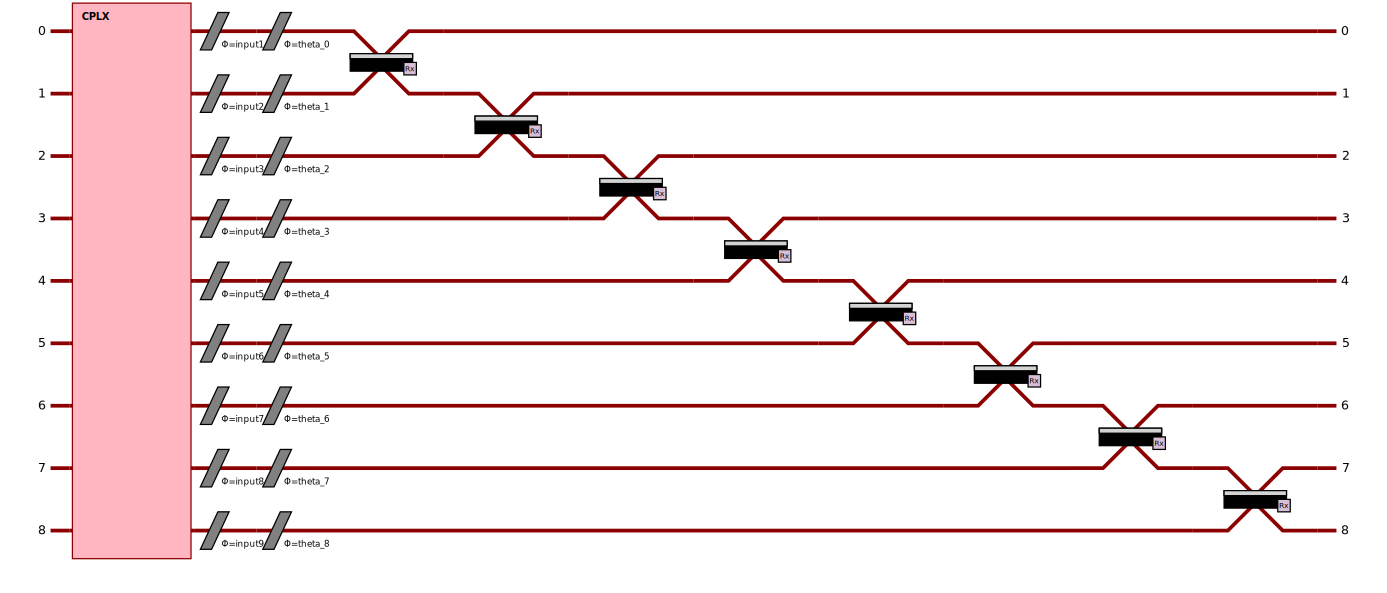

In [6]:
core = QuantumLayer(
    input_size=9,     # number of classical features
    builder=builder,
    n_photons=3,      # equivalent to input_state = [1,1,1,0,0,0]
    dtype=torch.float32,
)
pcvl.pdisplay(core.circuit)

In [7]:
class QuantumInterestRateModel(nn.Module):
    def __init__(
        self,
        input_dim: int,
        classical_hidden: int = 32,
        quantum_input_dim: int = 4,
        quantum_n_params: int = 64,
        head_hidden: int = 32,
        dropout: float = 0.1,
        dtype: torch.dtype = torch.float32,
    ):
        super().__init__()

        # 1) Classical "pre" block: map features -> quantum_input_dim
        self.pre = nn.Sequential(
            nn.Linear(input_dim, classical_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(classical_hidden, quantum_input_dim),
            nn.ReLU(),
        )

        # 2) Quantum layer from MerLin
        #    QuantumLayer.simple builds a ready-to-train photonic circuit
        #    with angle encoding + probabilities as outputs. 
        self.quantum = ML.QuantumLayer.simple(
            input_size=quantum_input_dim,
            n_params=quantum_n_params,
            dtype=dtype,
        )

        # quantum layer has an attribute output_size (length of probability vector) 
        q_out_dim = self.quantum.output_size

        # 3) Classical "head" block: quantum output -> scalar rate
        self.head = nn.Sequential(
            nn.Linear(q_out_dim, head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, input_dim)
        x = self.pre(x)          # -> (batch_size, quantum_input_dim)
        x = self.quantum(x)      # -> (batch_size, q_out_dim) probabilities / logits
        x = self.head(x)         # -> (batch_size, 1) regression output
        return x

In [8]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

input_dim = X_train_t.shape[1]

model = QuantumInterestRateModel(
    input_dim=input_dim,
    classical_hidden=32,
    quantum_input_dim=4,   # must match pre block output
    quantum_n_params=100,
    head_hidden=32,
    dropout=0.1,
    dtype=torch.float32,
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_mse = running_loss / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            test_loss += loss.item() * X_batch.size(0)
        test_mse = test_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1:3d} | train MSE: {train_mse:.6f} | test MSE: {test_mse:.6f}")

Epoch   1 | train MSE: 0.005302 | test MSE: 0.001181
Epoch   2 | train MSE: 0.000962 | test MSE: 0.000725
Epoch   3 | train MSE: 0.000629 | test MSE: 0.000721
Epoch   4 | train MSE: 0.000591 | test MSE: 0.000663
Epoch   5 | train MSE: 0.000564 | test MSE: 0.000323
Epoch   6 | train MSE: 0.000550 | test MSE: 0.000313
Epoch   7 | train MSE: 0.000530 | test MSE: 0.000543


In [15]:
RESULT_PATH = os.path.join(PROJECT_ROOT, r"training-data\data_results.csv")

df_input = pd.read_csv(RESULT_PATH, header=0 ,sep=';')
def add_model_predictions(df_input, model, scaler, df_train, feature_cols, target_col="value"):
    """
    Takes a raw dataframe with input columns and returns the same dataframe
    with an additional column 'prediction' computed by the model.
    
    df_input     : df with raw input columns (date, tenor, maturity, etc.)
    model        : trained PyTorch model
    scaler       : fitted StandardScaler used during training
    df_train     : original training DataFrame (needed for time_idx reference)
    feature_cols : list of columns used as model input
    target_col   : name of target column (optional)
    """
    
    df = df_input.copy()

    # -----------------------------
    # 1. Ensure date is datetime
    # -----------------------------
    df["date"] = pd.to_datetime(df["date"], dayfirst=True)

    # -----------------------------
    # 2. Feature engineering (same as training)
    # -----------------------------

    # time index using SAME reference
    df["time_idx"] = (df["date"] - df_train["date"].min()).dt.days

    # day-of-year + cyclic
    df["doy"] = df["date"].dt.dayofyear
    df["doy_sin"] = np.sin(2 * np.pi * df["doy"] / 365.25)
    df["doy_cos"] = np.cos(2 * np.pi * df["doy"] / 365.25)

    # -----------------------------
    # 3. Lag features (if in feature_cols)
    # -----------------------------
    uses_lags = any(col.startswith("rate_lag") for col in feature_cols)

    if uses_lags:
        group = df.groupby(["tenor", "maturity"])

        if "rate_lag1" in feature_cols:
            df["rate_lag1"] = group[target_col].shift(1)
        if "rate_lag5" in feature_cols:
            df["rate_lag5"] = group[target_col].shift(5)
        if "rate_lag10" in feature_cols:
            df["rate_lag10"] = group[target_col].shift(10)

        if "rate_diff1" in feature_cols:
            df["rate_diff1"] = df[target_col] - df["rate_lag1"]
        if "rate_diff5" in feature_cols and "rate_lag5" in df:
            df["rate_diff5"] = df[target_col] - df["rate_lag5"]

        # drop rows with missing lag values
        df = df.dropna(subset=[c for c in feature_cols if c.startswith("rate_")]).reset_index(drop=True)

    # -----------------------------
    # 4. Build model inputs
    # -----------------------------
    X = df[feature_cols].to_numpy(dtype=np.float32)
    X_scaled = scaler.transform(X).astype(np.float32)
    X_t = torch.tensor(X_scaled, dtype=torch.float32)

    # -----------------------------
    # 5. Run model prediction
    # -----------------------------
    model.eval()
    with torch.no_grad():
        preds = model(X_t).squeeze().cpu().numpy()

    # -----------------------------
    # 6. Append predictions to df
    # -----------------------------
    df["prediction"] = preds
    print(preds)

    return df

df_with_preds = add_model_predictions(
    df_input,
    model,
    scaler,
    train_df,
    feature_cols,
    target_col="value"
)

print(df_with_preds.head())


[0.06362348 0.06362348 0.06362348 ... 0.30254284 0.33735818 0.367566  ]
        date  tenor  maturity  Value  time_idx  doy   doy_sin   doy_cos  \
0 2051-12-24      1  0.083333    NaN       715  358 -0.124395  0.992233   
1 2051-12-24      1  0.250000    NaN       715  358 -0.124395  0.992233   
2 2051-12-24      1  0.500000    NaN       715  358 -0.124395  0.992233   
3 2051-12-24      1  0.750000    NaN       715  358 -0.124395  0.992233   
4 2051-12-24      1  1.000000    NaN       715  358 -0.124395  0.992233   

   prediction  
0    0.063623  
1    0.063623  
2    0.063623  
3    0.084384  
4    0.113965  


In [16]:
df_with_preds.to_csv("predictions_output.csv", index=False)

In [18]:
def regression_metrics(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    mae  = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true)**2))
    mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100
    r2   = 1 - np.sum((y_pred - y_true)**2) / np.sum((y_true - y_true.mean())**2)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
    }

model.eval()

with torch.no_grad():
    y_pred_t = model(X_test_t)          # torch tensor, shape (N,1)
    y_pred = y_pred_t.cpu().numpy().flatten()   # convert to 1D numpy array

metrics = regression_metrics(y_test, y_pred)
print(metrics)

{'MAE': np.float32(0.018980563), 'RMSE': np.float32(0.023305066), 'MAPE': np.float32(12.244418), 'R2': np.float32(0.9461599)}
